# Brain tumor detection using a CNN - Predict

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

### Parameters

In [3]:
test_dataset_path = './Brain Tumor Data Set/Test'

weights_export_path = './model_export/weights_only/brain_tumor_CNN'
model_export_path = './model_export/whole_model/'

batch_size = 32
img_height = 128
img_width = 128

seed = 42
random.seed(seed)

## Let's load our test set

In [4]:
# Test set
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dataset_path,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 253 files belonging to 2 classes.


In [5]:
# The class names derive from the folder structure
class_names = test_ds.class_names
print(class_names)

['Cancer', 'Not cancer']


## Let's load the model

### Option 1 - Just load the weights
In order to load the weights we need to recreate the exact model architecture used in the training process

In [6]:
# Recreate the model architecture
model = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  Conv2D(8, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Conv2D(16, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(rate=0.3),
  Dense(64, activation='relu'),
  Dropout(rate=0.3),
  Dense(1, activation="sigmoid")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [7]:
# Restore the weights
model.load_weights(weights_export_path)

### Option 2 - Load the whole model

In [11]:
model = tf.keras.models.load_model(model_export_path)

# Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0

## Let's evaluate our model

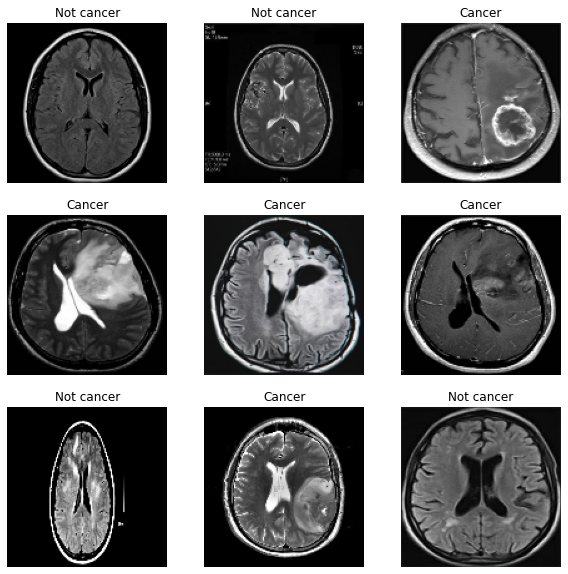

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
eval_out = model.evaluate(test_ds,
                          verbose=1)

print('Accuracy: {} \nLoss: {}'.format(round(eval_out[1], 2), round(eval_out[0], 2)))

8/8 [==============================] - 1s 70ms/step - loss: 0.0339 - accuracy: 0.9842
Accuracy: 0.98 
Loss: 0.03


## Let's try our model

1/1 [==============================] - 0s 31ms/step


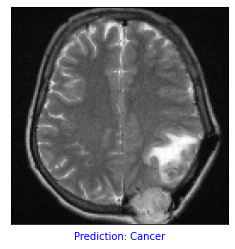

In [50]:
# Pick a random image
index_to_test = random.randrange(batch_size)

for images, labels in test_ds.take(1):
  test_image = images[index_to_test]
  test_image_class = labels[index_to_test]

# Predict it
predictions = model.predict(np.expand_dims(test_image, 0))

# Visualize the prediction
predicted_value = round(predictions[0][0])
true_value = tf.get_static_value(test_image_class)
label_color = 'blue' if predicted_value == true_value else 'red'

plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.xlabel("Prediction: {}".format(class_names[predicted_value]), color=label_color)
plt.imshow(test_image/255);